<a href="https://colab.research.google.com/github/supertime1/Floyer_Analysis/blob/main/Cosinuss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Set up dependency

In [1]:
import sys
sys.path.append('C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss')

In [2]:
from data_container import config, DataFile
from data_container.api_db_sync import DBSync
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

2021-02-22 11:52:30 - DEBUG -       dc_config:  45 - DcConfig initialized


#2.Connect to Cosinuss Database

In [3]:
def configure_api(db_name, username, update_local=False):
    """
    Configure api as the data handler
    """
    try:
        config.init(db_name=db_name)
        api = DBSync(username=username,
                    server = 'https://telecovid.earconnect.de')
    except:
        print('Configure API failed')
        return
    # password: teeshau7aiMonoh9ee
    if update_local:
    # download data from the server
        api.pull_all_dfs(prj_hash_id='M9KH')
    
    df_list_local = api.df_list(prj_hash_id='M9KH')
    print('There are', len(df_list_local), 'files in local database')
    return api


api = configure_api('sonova_analysis', 'sonova.fremont.api')

2021-02-22 11:52:33 -  INFO -       dc_config: 202 - data_path is "C:\Users\57lzhang.US04WW4008\PycharmProjects\cosinuss\data"
2021-02-22 11:52:33 -  INFO -       dc_config: 118 - connect to database "sonova_analysis"
2021-02-22 11:52:33 -  INFO -       dc_config: 113 - init of data_container successful
2021-02-22 11:52:34 -  INFO -       api_login: 241 - login: sonova.fremont.api @ https://telecovid.earconnect.de
2021-02-22 11:52:35 -  INFO -       api_login: 253 - successful login, it expires 2021-02-22 23:52:35 expiring in 720.0 min


There are 163 files in local database


In [59]:
def generate_table(date):
    """
    Convert local database into a Pandas dataframe, for ease of data analysis

    params:
    date: select the date that data is generated

    outputs:
    an overview table in the form of pandas dataframe
    """
    table = api.overview_dfs()
    overview_df = pd.DataFrame(table[1:], columns=table[0])
    # change to lower case for the device name
    overview_df['device'] = overview_df['device'].str.lower()
    overview_df.loc[overview_df.device.str.match(r'^polar'), 'device']= 'polar'
    overview_df = overview_df[overview_df.when > date]

    return overview_df

table = generate_table('2020-12-31')
print('There are', len(table), 'test records')
table.head()

There are 63 test records


,person,when,device,df id,duration,samples,cols
100,M9KH.BZYG (RaHe),2021-02-08 14:15:09,polar,1C2RATHBVH.C4CDEZ,00:34:48,2.1 K,heart_rate
101,M9KH.BZYG (RaHe),2021-02-08 14:15:14,cshell,1C2RATHBVH.38CD8K,00:34:42,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
102,M9KH.BZYG (RaHe),2021-02-08 14:15:23,cshell,1C2RATHBVH.LEMWKL,00:34:36,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
103,M9KH.BZYG (RaHe),2021-02-08 14:15:35,garmin,8QEK89R9B4.NZH5XL,00:45:27,2.7 K,heart_rate
104,M9KH.ME9A (LeLo),2021-02-08 15:23:00,polar,1C2RATHBVH.XCMFW1,00:34:34,2.1 K,heart_rate


In [ ]:
 def correct_label(table):
    """
    fix the labeling problem of cshell and biometric
    
    params:
    overview table from generate_table function

    outputs:
    updated table with correct cshell and biometric labels

    """
    def get_device_model(df):
        """
        get device
        
        params:
        df - output of api.pull_df
        
        outputs:
        correct device label for df
        """
        # get device
        if df.device:
            device_model = df.device.device_model
        else:
            device_model = df.device_model
        
        if 'polar' in device_model.lower():
            return 'polar'

        elif 'biomeric' in device_model.lower() or 'cshell' in device_model.lower():
            if 'ppg_ir_2' in list(df.cols):
                some_data = df.c.ppg_ir_2.y[600:650]
                if list(some_data):
                    ppg_mean = np.mean(some_data)
                else:
                    return 'na'
            else:
                ppg_mean = 1000
            
            if ppg_mean < 500:
                return 'cshell'
            else:
                return 'biometric'
    
    def get_correct_label(hash_ids, target_device):
        """

        """
        # output list of corrected labels
        corrected_name = []
        # a counter to record how many labels have been corrected after processing
        cnt = 0
        print(f'There are in total {len(hash_ids)} files with {target_device} label')
        for i in range(len(hash_ids)):
            try:
                print(f'api reading {i}th file...')
                df = api.pull_df(np.asarray(hash_ids)[i]) 
            # in case reading file failed
            except:
                print(f'api read {i}th file failed!')
                corrected_name.append(table.loc[hash_ids.index[i]].device)
                continue
            # get the new label by api reading the file
            new_label = get_device_model(df)
            corrected_name.append(new_label)
            if new_label != table.loc[hash_ids.index[i]].device:
                print(f'Person {table.loc[hash_ids.index[i]].person} and \
            {target_device} label has been corrected to {new_label}')
                cnt += 1
        print(f'There are in total {cnt} files been corrected')
        return corrected_name

    # get the hash ids of cshell and biometric in orginal table
    cshell_hash_ids = table[table.device == 'cshell']['df id']
    biometric_hash_ids = table[table.device == 'biometric']['df id']
    # use the hash ids to get the correct labels of cshell and biometric
    corrected_cshell_device_name = get_correct_label(cshell_hash_ids, 
                                                     'cshell')
    corrected_biometric_device_name = get_correct_label(biometric_hash_ids, 
                                                        'biometric')

    # update the orginal table with corrected labes of cshell and biometric
    original_cshell_index = (table.device == 'cshell').index
    original_biometric_index = (table.device == 'biometric').index

    table.device.loc[original_cshell_index] = corrected_cshell_device_name
    table.device.loc[original_biometric_index] = corrected_biometric_device_name


    return table

table = correct_label(table)

There are in total 32 files with cshell label
api reading 0th file...


In [23]:
table[table.device == 'cshell']

,person,when,device,df id,duration,samples,cols
101,M9KH.BZYG (RaHe),2021-02-08 14:15:14,cshell,1C2RATHBVH.38CD8K,00:34:42,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
102,M9KH.BZYG (RaHe),2021-02-08 14:15:23,cshell,1C2RATHBVH.LEMWKL,00:34:36,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
105,M9KH.ME9A (LeLo),2021-02-08 15:23:07,cshell,1C2RATHBVH.C4KKHL,00:34:22,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
106,M9KH.ME9A (LeLo),2021-02-08 15:23:15,cshell,1C2RATHBVH.G2HHR3,00:34:21,1.6 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
109,M9KH.03GS (DaBi),2021-02-08 16:09:53,cshell,1C2RATHBVH.RG2ZUB,00:34:16,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
110,M9KH.03GS (DaBi),2021-02-08 16:10:00,cshell,1C2RATHBVH.3DT9PX,00:34:10,1.6 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
113,M9KH.BZYG (RaHe),2021-02-08 17:17:25,cshell,1C2RATHBVH.FTZLPT,00:34:08,1.6 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
114,M9KH.BZYG (RaHe),2021-02-08 17:17:33,cshell,1C2RATHBVH.95P86S,00:34:03,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
115,M9KH.UZSF (GeSc),2021-02-09 09:39:23,cshell,1C2RATHBVH.DFEWY2,00:34:02,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
116,M9KH.UZSF (GeSc),2021-02-09 09:39:30,cshell,1C2RATHBVH.009DDE,00:33:56,1.6 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."


In [13]:
table[table.device == 'biometric']

,person,when,device,df id,duration,samples,cols


In [10]:
paired_table = table[table.device.isin(['polar', 'cshell'])] 

In [11]:
paired_table

,person,when,device,df id,duration,samples,cols
100,M9KH.BZYG (RaHe),2021-02-08 14:15:09,polar,1C2RATHBVH.C4CDEZ,00:34:48,2.1 K,heart_rate
101,M9KH.BZYG (RaHe),2021-02-08 14:15:14,cshell,1C2RATHBVH.38CD8K,00:34:42,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
102,M9KH.BZYG (RaHe),2021-02-08 14:15:23,cshell,1C2RATHBVH.LEMWKL,00:34:36,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
104,M9KH.ME9A (LeLo),2021-02-08 15:23:00,polar,1C2RATHBVH.XCMFW1,00:34:34,2.1 K,heart_rate
105,M9KH.ME9A (LeLo),2021-02-08 15:23:07,cshell,1C2RATHBVH.C4KKHL,00:34:22,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
106,M9KH.ME9A (LeLo),2021-02-08 15:23:15,cshell,1C2RATHBVH.G2HHR3,00:34:21,1.6 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
109,M9KH.03GS (DaBi),2021-02-08 16:09:53,cshell,1C2RATHBVH.RG2ZUB,00:34:16,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
110,M9KH.03GS (DaBi),2021-02-08 16:10:00,cshell,1C2RATHBVH.3DT9PX,00:34:10,1.6 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
112,M9KH.BZYG (RaHe),2021-02-08 17:17:20,polar,1C2RATHBVH.B6WZ94,00:34:11,2.0 K,heart_rate
113,M9KH.BZYG (RaHe),2021-02-08 17:17:25,cshell,1C2RATHBVH.FTZLPT,00:34:08,1.6 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."


In [121]:
person_paired_table = paired_table[paired_table.person == 'M9KH.C37E (MeBa)']
person_paired_table

,person,when,device,df id,duration,samples,cols
124,M9KH.C37E (MeBa),2021-02-09 11:06:28,cshell,1C2RATHBVH.C0KF6Y,00:35:10,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
125,M9KH.C37E (MeBa),2021-02-09 11:06:37,cshell,1C2RATHBVH.LBYCML,00:35:03,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_..."
126,M9KH.C37E (MeBa),2021-02-09 11:06:50,polar,1C2RATHBVH.60SWCR,00:34:53,2.1 K,heart_rate


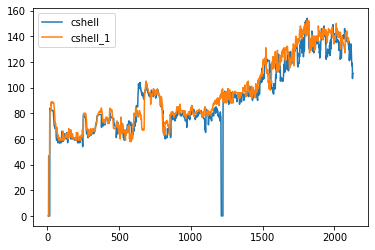

In [95]:
cshell = api.one3_hr_algo('v0', '1C2RATHBVH.LBYCML')
cs_hr_x = np.asarray(cshell['heart_rate_t'])
cs_hr_y = cshell['heart_rate']
cd_q = cshell['quality']
plt.plot(cs_hr_x, cs_hr_y, label='cshell')

cshell1 = api.one3_hr_algo('v0', '1C2RATHBVH.C0KF6Y')
cs_hr_x_1 = np.asarray(cshell1['heart_rate_t'])
cs_hr_y_1 = cshell1['heart_rate']
cd_q1 = cshell1['quality']
plt.plot(cs_hr_x_1, cs_hr_y_1, label='cshell_1')
plt.legend()
plt.show()

In [ ]:
cshell = api.one3_hr_algo('v0', '1C2RATHBVH.LBYCML')
cs_hr_x = np.asarray(cshell['heart_rate_t'])
cs_hr_y = cshell['heart_rate']
cd_q = cshell['quality']
plt.plot(cs_hr_x, cs_hr_y)

In [ ]:
def pair_polar_floyer(table, paired_lst=['polar','cshell']):
    """
    Filter table with paired polar and floyer devices
    """
    paired_table = table[table.device.isin(paried_lst)]
    
    # find paried sample ids
    person_lst = paired_table['person']
    for person in person_lst:
        person_paired_table = paired_table[paired_table.person == person]
        

In [ ]:
#convert time to seconds in integer
#fill
class PairedSample:
    
    def __init__(self, polar_hash_id, floyer_hash_id, hr_algo_version):
        self.polar_hash_id = polar_hash_id
        self.floyer_hash_id = floyer_hash_id
        self.df_polar = DataFile.objects(_hash_id=polar_hash_id).first()
        self.df_floyer = DataFile.objects(_hash_id=floyer_hash_id).first()
        self.hr_algo_version = hr_algo_version
    
    def process(self):
        # calculate floyer heart rate
        floyer = imp.one3_hr_algo(self.hr_algo_version, self.floyer_hash_id)
        floyer_hr_x = np.asarray(floyer['heart_rate_t'])
        floyer_hr_y = floyer['heart_rate']

        # get polar heart rate 
        po_hr_x = self.df_polar.c.heart_rate.x
        po_hr_y = self.df_polar.c.heart_rate.y

        # calculate offsets (i.e. floyer and polar maynot start recording at the
        # same time)
        offset = (df_cshell.date_time_start - 
                  df_polar.date_time_start).total_seconds() + 2098
        # make sure two devices start at the same time
        po_hr_x = po_hr_x[offset:]
        po_hr_y = po_hr_y[offset:]

        # create a new dataframe with three columns: time (s), p_hr, f_hr
        


        self.mape = self.mape() 
        self.icc = self.icc()
        self.da = self.da()

    def mape(self):
    
    def icc(self):
    
    def da(self):

    def line_plot(self):

    def ba_plot(self):

    

In [10]:
# download data if it is not in local database
#df_cshell = imp.pull_df('8QEK89R9B4.2NTSXK')

#import cShell data
df_cshell = DataFile.objects(_hash_id='8QEK89R9B4.2NTSXK').first()
cshell = imp.one3_hr_algo('v0', '8QEK89R9B4.2NTSXK')
cshell.keys()
cs_hr_x = np.asarray(cshell['heart_rate_t'])
cs_hr_y = cshell['heart_rate']
cd_q = cshell['quality']

In [15]:
#import polar data
df_ploar = imp.pull_df('003RN9.36G4ZN')

df_polar = DataFile.objects(_hash_id='003RN9.36G4ZN').first()
po_hr_x = df_polar.c.heart_rate.x
po_hr_y = df_polar.c.heart_rate.y
offset = (df_cshell.date_time_start - 
          df_polar.date_time_start).total_seconds() + 2098

2021-02-18 10:22:19 -  INFO -     api_db_sync: 429 - Data file 003RN9.36G4ZN completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


In [45]:
new = np.asarray([round(i) for i in po_hr_x])

In [46]:
new

array([   5,    6,    7, ..., 5317, 5318, 5319])

In [47]:
cs_hr_x

array([   7,    8,    9, ..., 1605, 1606, 1607])

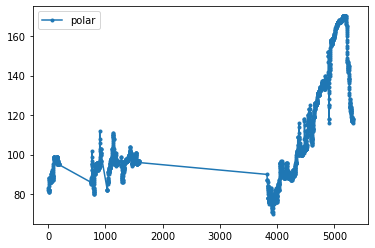

In [31]:
plt.plot(po_hr_x[100], po_hr_y, marker='.', label='polar')
#plt.plot(cs_hr_x+offset, cs_hr_y, marker='.', label='cshell')
plt.legend()
plt.show()

# New Section